# Visualise Trove newspaper searches over time

You know the feeling. You enter a query into [Trove's digitised newspapers](https://trove.nla.gov.au/newspaper/) search box and...

![Trove search results screen capture](images/trove-newspaper-results.png)

Hmmm, **3 million results**, how do you make sense of that..?

Trove tries to be as helpful as possible by ordering your results by relevance. This is great if you aim is to find a few interesting articles. But how can you get a sense of the complete results set? How can you *see* everything? Trove's web interface only shows you the first 2,000 articles matching your search. But by getting data directly from the [Trove API](https://help.nla.gov.au/trove/building-with-trove/api) we can go bigger. 

This notebook helps you zoom out and explore how the number of newspaper articles in your results varies over time by using the `decade` and `year` facets. We'll then combine this approach with other search facets to see how we can slice a set of results up in different ways to investigate historical changes.

1. [Setting things up](#1.-Setting-things-up)
2. [Find the number of articles per year using facets](#2.-Find-the-number-of-articles-per-year-using-facets)
3. [How many articles in total were published each year?](#3.-How-many-articles-in-total-were-published-each-year?)
4. [Charting our search results as a proportion of total articles](#4.-Charting-our-search-results-as-a-proportion-of-total-articles)
5. [Comparing multiple search terms over time](#5.-Comparing-multiple-search-terms-over-time)
6. [Comparing a search term across different states](#6.-Comparing-a-search-term-across-different-states)
7. [Comparing a search term across different newspapers](#7.-Comparing-a-search-term-across-different-newspapers)
8. [Chart changes in illustration types over time](#8.-Chart-changes-in-illustration-types-over-time)
9. [But what are we searching?](#9.-But-what-are-we-searching?)
10. [Next steps](#10.-Next-steps)
11. [Related resources](#11.-Related-resources)
12. [Further reading](#12.-Further-reading)


<div class="alert alert-block alert-warning">
<p>If you haven't used one of these notebooks before, they're basically web pages in which you can write, edit, and run live code. They're meant to encourage experimentation, so don't feel nervous. Just try running a few cells and see what happens!</p>

<p>
    Some tips:
    <ul>
        <li>Code cells have boxes around them.</li>
        <li>To run a code cell click on the cell and then hit <b>Shift+Enter</b>. The <b>Shift+Enter</b> combo will also move you to the next cell, so it's a quick way to work through the notebook.</li>
        <li>While a cell is running a <b>*</b> appears in the square brackets next to the cell. Once the cell has finished running the asterix will be replaced with a number.</li>
        <li>In most cases you'll want to start from the top of notebook and work your way down running each cell in turn. Later cells might depend on the results of earlier ones.</li>
        <li>To edit a code cell, just click on it and type stuff. Remember to run the cell once you've finished editing.</li>
    </ul>
</p>

<p><b>Is this thing on?</b> If you can't edit or run any of the code cells, you might be viewing a static (read only) version of this notebook. Click here to load a <b>live</b> version running on Binder.</p>
</div>

## 1. Setting things up

### Import what we need

In [1]:
import requests
import os
import ipywidgets as widgets
from operator import itemgetter # used for sorting
import pandas as pd # makes manipulating the data easier
import altair as alt
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm.auto import tqdm
from IPython.display import display, HTML, FileLink, clear_output
import math
from collections import OrderedDict
import time

# Make sure data directory exists
os.makedirs('data', exist_ok=True)

# Create a session that will automatically retry on server errors
s = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[ 502, 503, 504 ])
s.mount('http://', HTTPAdapter(max_retries=retries))
s.mount('https://', HTTPAdapter(max_retries=retries))

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

The next cell sets the renderer for Altair. If you're using the classic Jupyter notebook, just run the cell as normal. If you're using Jupyter Lab, don't run it!

In [ ]:
# Are you using Jupyter Lab?
# If so either don't run this cell or comment out the line below

alt.renderers.enable('notebook')

# If you forget, run this cell, and then get strange warnings when you make a chart,
# uncomment the following line and run this cell to reset the chart renderer

# alt.renderers.enable('default')

### Enter a Trove API key

We're going to get our data from the Trove API. You'll need to get your own [Trove API key](http://help.nla.gov.au/trove/building-with-trove/api) and enter it below.

In [2]:
api_key = 'YOUR API KEY'
print('Your API key is: {}'.format(api_key))

Your API key is: 6pi5hht0d2umqcro


## 2. Find the number of articles per year using facets

<img src="images/trove-decade-facets.png" width="200" align="left" style="border: 1px solid #d6d6d6; margin-right: 20px">

When you search for newspaper articles using Trove's web interface, the results appear alongside a column headed 'Refine your results'. This column displays summary data extracted from your search, such as the states in which articles were published and the newspapers that published them. In the web interface, you can use this data to filter your results, but using the API we can retrieve the raw data and use it to visualise the complete result set.

Here you can see the decade facet, showing the number of newspaper articles published each decade. If you click on a decade, the interface displays the number of results per year. So sitting underneath the web interface is data that breaks down our search results by year. Let's use this data to visualise a search over time.

To get results by year from the Trove API, you need to set the `facet` parameter to `year`. However, this only works if you've also selected a specific decade using the `l-decade` parameter. In other words, you can only get one decade's worth of results at a time. To assemble the complete dataset, you need to loop through all the decades, requesting the `year` data for each decade in turn.

Let's start with some basic parameters for our search.

In [3]:
# Basic parameters for Trove API
params = {
    'facet': 'year', # Get the data aggregated by year.
    'zone': 'newspaper',
    'key': api_key,
    'encoding': 'json',
    'n': 0 # We don't need any records, just the facets!
}

But what are we searching for? We need to supply a `q` parameter that includes our search terms. We can use pretty much anything that works in the Trove simple search box. This includes boolean operators, phrase searches, and proximity modifiers. But let's start with something simple. Feel free to modify the `q` value in the cell below.

In [4]:
# CHANGE THIS TO SEARCH FOR SOMETHING ELSE!
params['q'] = 'radio'

Let's define a couple of handy functions for getting facet data from the Trove API. 

In [5]:
def get_results(params):
    '''
    Get JSON response data from the Trove API.
    Parameters:
        params
    Returns:
        JSON formatted response data from Trove API 
    '''
    response = s.get('https://api.trove.nla.gov.au/v2/result', params=params, timeout=30)
    response.raise_for_status()
    # print(response.url) # This shows us the url that's sent to the API
    data = response.json()
    return data

def get_facets(data):
    '''
    Loop through facets in Trove API response, saving terms and counts.
    Parameters:
        data  - JSON formatted response data from Trove API  
    Returns:
        A list of dictionaries containing: 'year', 'total_results'
    '''
    facets = []
    try:
        # The facets are buried a fair way down in the results
        # Note that if you ask for more than one facet, you'll have use the facet['name'] param to find the one you want
        # In this case there's only one facet, so we can just grab the list of terms (which are in fact the results by year)
        for term in data['response']['zone'][0]['facets']['facet']['term']:
            
            # Get the year and the number of results, and convert them to integers, before adding to our results
            facets.append({'year': int(term['search']), 'total_results': int(term['count'])})
            
        # Sort facets by year
        facets.sort(key=itemgetter('year'))
    except TypeError:
        pass
    return facets

Now we'll define a function to loop through the decades, processing each in turn. 

To loop through the decades we need to define start and end points. Trove includes newspapers from 1803 right through until the current decade. Note that Trove expects decades to be specified using the first three digits of a year – so the decade value for the 1800s is just `180`. So let's set our range by giving `180` and `201` to the function as our default `start_decade` and `end_decade` values. Also note that I'm defining them as numbers, not strings (no quotes around them!). This is so that we can use them to build a range.

This function returns a list of dictionaries with values for `year` and `total_results`.

In [31]:
def get_facet_data(params, start_decade=180, end_decade=201):
    '''
    Loop throught the decades from 'start_decade' to 'end_decade',
    getting the number of search results for each year from the year facet.
    Combine all the results into a single list.
    Parameters:
        params - parameters to send to the API
        start_decade
        end_decade
    Returns:
        A list of dictionaries containing 'year', 'total_results' for the complete 
        period between the start and end decades.
    '''
    # Create a list to hold the facets data
    facet_data = []
    
    # Loop through the decades
    for decade in tqdm(range(start_decade, end_decade + 1)):
        
        # Avoid confusion by copying the params before we change anything.
        search_params = params.copy()
        
        # Add decade value to params
        search_params['l-decade'] = decade
        
        # Get the data from the API
        data = get_results(search_params)
        
        # Get the facets from the data and add to facets_data
        facet_data += get_facets(data)
        
        # Try not to go over API rate limit - increase if you get 403 errors
        time.sleep(0.2)
        
    # Reomve the progress bar (you can also set leave=False in tqdm, but that still leaves white space in Jupyter Lab)
    clear_output()
    return facet_data

In [7]:
# Call the function and save the results to a variable called facet_data
facet_data = get_facet_data(params)

For easy exploration, we'll convert the facet data into a [Pandas](https://pandas.pydata.org/) DataFrame.

In [8]:
# Convert our data to a dataframe called df
df = pd.DataFrame(facet_data)

# Let's have a look at the first few rows of data
df.head()

,total_results,year
0,1,1827
1,2,1830
2,1,1832
3,1,1833
4,4,1834


Which year had the most results? We can use `idxmax()` to find out.

In [9]:
# Show the row that has the highest value in the 'total_results' column.
# Use .idxmax to find the row with the highest value, then use .loc to get it
df.loc[df['total_results'].idxmax()]

total_results    132270
year               1941
Name: 111, dtype: int64

Now let's display the data as a chart using [Altair](https://altair-viz.github.io/index.html).

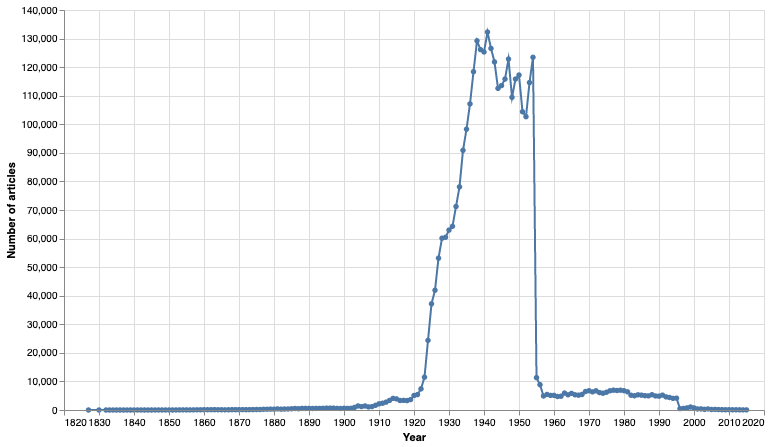

In [10]:
alt.Chart(df).mark_line(point=True).encode(
        # Years on the X axis
        x=alt.X('year:Q', axis=alt.Axis(format='c', title='Year')),
    
        # Number of articles on the Y axis
        y=alt.Y('total_results:Q', axis=alt.Axis(format=',d', title='Number of articles')),
    
        # Display details when you hover over a point
        tooltip=[alt.Tooltip('year:Q', title='Year'), alt.Tooltip('total_results:Q', title='Articles', format=',')]
    ).properties(width=700, height=400)

No suprise to see a sudden increase in the use of the word 'radio' in the early decades of the 20th century, but why do the results drop away after 1954? To find out we have to dig a bit deeper into Trove.

## 3. How many articles in total were published each year?

Ok, we've visualised a search in Trove's digitised newspapers. Our chart shows a clear change in the number of articles over time, but are we really observing a historical shift relating to the topic, or is this just because more newspapers were published at particular times? To explore this further, let's create another chart, but this time we'll search for *everything*. The way we do this is by setting the `q` parameter to ' ' – a single space.

First let's get the data.

In [11]:
# Reset the 'q' parameter
# Use a an empty search (a single space) to get ALL THE ARTICLES
params['q'] = ' '

# Get facet data for all articles
all_facet_data = get_facet_data(params)

Now let's create the chart.

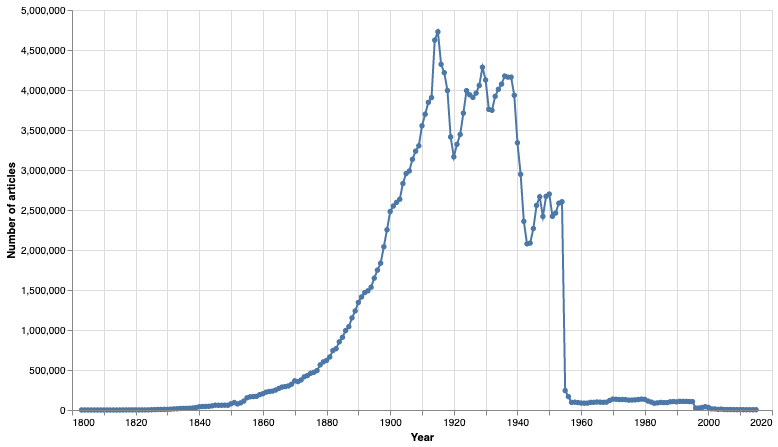

In [12]:
# Convert the results to a dataframe
df_total = pd.DataFrame(all_facet_data)

# Make a chart 
alt.Chart(df_total).mark_line(point=True).encode(
        # Display the years along the X axis
        x=alt.X('year:Q', axis=alt.Axis(format='c', title='Year')),
        
        # Display the number of results on the Y axis (formatted using thousands separator)
        y=alt.Y('total_results:Q', axis=alt.Axis(format=',d', title='Number of articles')),
        
        # Create a tooltip when you hover over a point to show the data for that year
        tooltip=[alt.Tooltip('year:Q', title='Year'), alt.Tooltip('total_results:Q', title='Articles', format=',')]
    ).properties(width=700, height=400)

This chart shows us the total number of newspaper articles in Trove for each year from 1803 to 2013. As you might expect, there's a steady increase in the number of articles published across the 19th century. But why is there such a notable peak in 1915, and why do the numbers drop away so suddenly in 1955? The answers are explored more fully in [this notebook](visualise-total-newspaper-articles-by-state-year.ipynb), but in short they're a reflection of digitisation priorities and copyright restrictions – they're artefacts of the environment in which Trove's newspapers are digitised.

The important point is that our original chart showing search results over time is distorted by these underlying features. Radios didn't suddenly go out of fashion in 1955!

## 4. Charting our search results as a proportion of total articles

One way of lessening the impact of these distortions is to show the number of search results as a proportion of the total number of articles available on Trove from that year. We've just harvested the total number of articles, so to get the proportion all we have to do is divide the original number of search results for each year by the total number of articles. Again, Pandas makes this sort of manipulation easy.

Below we'll define a function that takes two dataframes – the search results, and the total results – merges them, and then calculates what proportion of the total that the search results represent.

In [13]:
def merge_df_with_total(df, df_total):
    '''
    Merge dataframes containing search results with the total number of articles by year.
    This is a left join on the year column. The total number of articles will be added as a column to 
    the existing results.
    Once merged, do some reorganisation and calculate the proportion of search results.
    Parameters:
        df - the search results in a dataframe
        df_total - total number of articles per year in a dataframe
    Returns:
        A dataframe with the following columns - 'year', 'total_results', 'total_articles', 'proportion' 
        (plus any other columns that are in the search results dataframe).
    '''
    # Merge the two dataframes on year
    # Note that we're joining the two dataframes on the year column
    df_merged = pd.merge(df, df_total, how='left', on='year')

    # Rename the columns for convenience
    df_merged.rename({'total_results_y': 'total_articles'}, inplace=True, axis='columns')
    df_merged.rename({'total_results_x': 'total_results'}, inplace=True, axis='columns')

    # Set blank values to zero to avoid problems
    df_merged['total_results'] = df_merged['total_results'].fillna(0).astype(int)

    # Calculate proportion by dividing the search results by the total articles
    df_merged['proportion'] = df_merged['total_results'] / df_merged['total_articles']
    return df_merged

Let's merge!

In [14]:
# Merge the search results with the total articles
df_merged = merge_df_with_total(df, df_total)
df_merged.head()

,total_results,year,total_articles,proportion
0,1,1827,6537,0.000153
1,2,1830,8369,0.000239
2,1,1832,13732,0.000073
3,1,1833,15438,0.000065
4,4,1834,18704,0.000214


Now we have a new dataframe `df_merged` that includes both the raw number of search results for each year, and the proportion the results represent of the total number of articles on Trove. Let's create charts for both and look at the diferences.

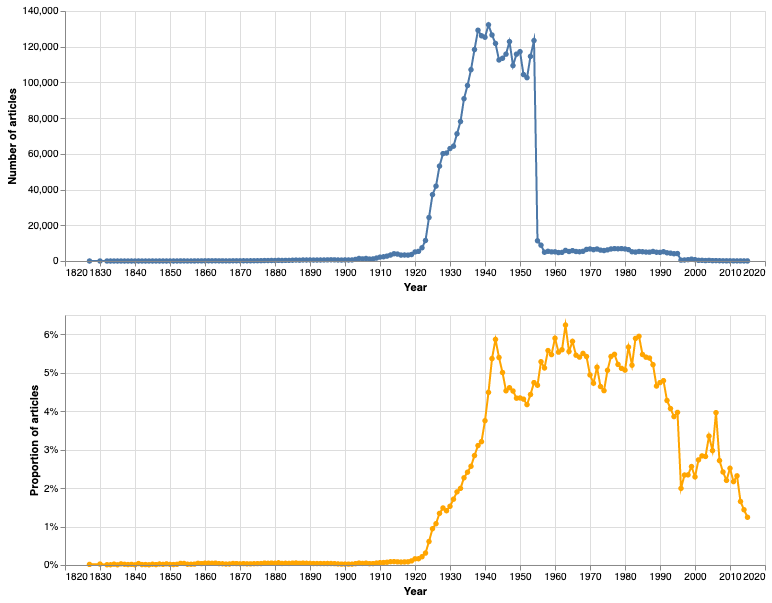

In [15]:
# This is the chart showing raw results -- it's the same as the one we created above (but a bit smaller)
chart1 = alt.Chart(df).mark_line(point=True).encode(
        x=alt.X('year:Q', axis=alt.Axis(format='c', title='Year')),
        y=alt.Y('total_results:Q', axis=alt.Axis(format=',d', title='Number of articles')),
        tooltip=[alt.Tooltip('year:Q', title='Year'), alt.Tooltip('total_results:Q', title='Articles', format=',')]
    ).properties(width=700, height=250)

# This is the new view, note that it's using the 'proportion' column for the Y axis
chart2 = alt.Chart(df_merged).mark_line(point=True, color='red').encode(
        x=alt.X('year:Q', axis=alt.Axis(format='c', title='Year')),
    
        # This time we're showing the proportion (formatted as a percentage) on the Y axis
        y=alt.Y('proportion:Q', axis=alt.Axis(format='%', title='Proportion of articles')),
        tooltip=[alt.Tooltip('year:Q', title='Year'), alt.Tooltip('proportion:Q', title='Proportion', format='%')],
        
        # Make the charts different colors
        color=alt.value('orange')
    ).properties(width=700, height=250)

# This is a shorthand way of stacking the charts on top of each other
chart1 & chart2

The overall shape of the two charts is similar, but there are some significant differences. Both show a dramatic increase after 1920, but the initial peaks are in different positions. The sudden drop-off after 1954 has gone, and we even have a new peak in 1963. Why 1963? The value of these sorts of visualisations is in the questions they prompt, rather than any claim to 'accuracy'. How meaningful are the post-1954 results? If we [break down the numbers by state](visualise-total-newspaper-articles-by-state-year.ipynb), we see that the post-1954 results are mostly from the ACT. It is a small, narrowly-focused sample. Reading these two charts in combination reminds us that the structure and content of a large corpus like Trove is not natural. While viewing the number of results over time can alert us to historical shifts, we have to be prepared to ask questions about how those results are generated, and what they represent.

## 5. Comparing multiple search terms over time

Another way of working around inconsistencies in the newspaper corpus is to *compare* search queries. While the total numbers could be misleading, the comparative numbers might still show us interesting shifts in usage or meaning. Once again, this is not something we can do through the web interface, but all we need to achieve this using the API is a few minor adjustments to our code.

Instead of a single search query, this time we'll define a list of search queries. You can include as many queries as you want and, once again, the queries can be anything you'd type in the Trove search box.

In [16]:
# Create a list of queries
queries = [
    'telegraph',
    'radio',
    'wireless'
]

Now we'll define a new function that loops through each of the search terms, retrieving the facet data for each, and combining it all into a single dataframe.

In [17]:
def get_search_facets(params, queries):
    '''
    Process a list of search queries, gathering the facet data for each and combining the results into a single dataframe.
    
    Parameters:
        params - basic parameters to send to the API
        queries - a list of search queries
    Returns:
        A dataframe
    '''
    # This is where we'll store the invididual dataframes
    dfs = []
    
    # Make a copy of the basic parameters
    these_params = params.copy()
    
    # Loop through the list of queries
    for q in queries:
        
        # Set the 'q' parameter to the current search query
        these_params['q'] = q
        
        # Get all the facet data for this search
        facet_data = get_facet_data(these_params)
        
        # Convert the facet data into a dataframe
        df = pd.DataFrame(facet_data)
        
        # Add a column with the search query -- this will enable us to distinguish between the results in the combined dataframe.
        df['query'] = q
        
        # Add this df to our list
        dfs.append(df)
        
    # Combine the dfs into one df using concat and return the result
    return pd.concat(dfs)

Now we're ready to harvest some data!

In [18]:
df_queries = get_search_facets(params, queries)

Once again, it would be useful to have the number of search results as a proportion of the total articles, so let's use our merge function again to add the proportions.

In [19]:
df_queries_merged = merge_df_with_total(df_queries, df_total)

As we're repeating the same sorts of charts with different data, we might as well save ourselves some effort by creating a couple of reusable charting functions. One shows the raw numbers, and the other shows the proportions.

In [20]:
def make_chart_totals(df, category, category_title):
    '''
    Make a chart showing the raw number of search results over time.
    Creates different coloured lines for each query or category.
    Parameters:
        df - a dataframe
        category - the column containing the value that distinguishes multiple results set (eg 'query' or 'state')
        category_title - a nicely formatted title for the category to appear above the legend
    '''
    chart = alt.Chart(df).mark_line(point=True).encode(
        
        # Show the year on the X axis
        x=alt.X('year:Q', axis=alt.Axis(format='c', title='Year')),
        
        # Show the total number of articles on the Y axis (with thousands separator)
        y=alt.Y('total_results:Q', axis=alt.Axis(format=',d', title='Number of articles')),
        
        # Display query/category, year, and number of results on hover
        tooltip=[alt.Tooltip('{}:N'.format(category), title=category_title), alt.Tooltip('year:Q', title='Year'), alt.Tooltip('total_results:Q', title='Articles', format=',')],
        
        # In these charts were comparing results, so we're using color to distinguish between queries/categories
        color=alt.Color('{}:N'.format(category), legend=alt.Legend(title=category_title))
    ).properties(width=700, height=250)
    return chart


def make_chart_proportions(df, category, category_title):
    '''
    Make a chart showing the proportion of search results over time.
    Creates different coloured lines for each query or category.
    Parameters:
        df - a dataframe
        category - the column containing the value that distinguishes multiple results set (eg 'query' or 'state')
        category_title - a nicely formatted title for the category to appear above the legend
    '''
    chart = alt.Chart(df).mark_line(point=True).encode(
        # Show the year on the X axis
        x=alt.X('year:Q', axis=alt.Axis(format='c', title='Year')),
        
        # Show the proportion of articles on the Y axis (formatted as percentage)
        y=alt.Y('proportion:Q', axis=alt.Axis(format='%', title='Proportion of articles'), stack=None),
        
        # Display query/category, year, and proportion of results on hover
        tooltip=[alt.Tooltip('{}:N'.format(category), title=category_title), alt.Tooltip('year:Q', title='Year'), alt.Tooltip('proportion:Q', title='Proportion', format='%')],
        
        # In these charts were comparing results, so we're using color to distinguish between queries/categories
        color=alt.Color('{}:N'.format(category), legend=alt.Legend(title=category_title))
    ).properties(width=700, height=250)
    return chart

Let's use the new functions to create charts for our queries.

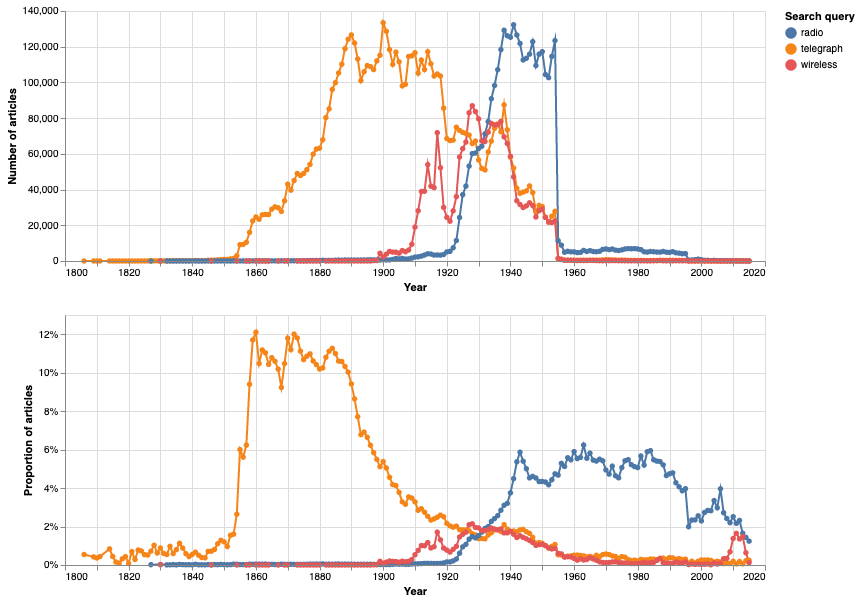

In [21]:
# Chart total results
chart3 = make_chart_totals(df_queries_merged, 'query', 'Search query')

# Chart proportions
chart4 = make_chart_proportions(df_queries_merged, 'query', 'Search query')

# Shorthand way of concatenating the two charts (note there's only one legend)
chart3 & chart4

Once again, it's interesting to compare the total results with the proportions. In this case, both point to something interesting happening around 1930. To explore this further we could use the [Trove Newspaper Harvester](https://glam-workbench.github.io/trove-harvester/) to assemble a dataset of articles from 1920 to 1940 for detailed analysis. You might also notice a little peak for 'wireless' around 2011 – new uses for old words!

## 6. Comparing a search term across different states

Another way of building comparisons over time is to use some of the other facets available in Trove to slice up our search results. For example, the `state` facet tells us the number of results per state. We might be able to use this to track differences in language, or regional interest in particular events.

Because we're combining three facets, `state` and `decade`/`year`, we need to think a bit about how we assemble the data. In this case we're only using one search query, but we're repeating this query across a number of different states. We're then getting the data for decade and year for each of the states.

The possible values for the `state` facet are:

* ACT
* New South Wales
* Northern Territory
* Queensland
* South Australia
* Tasmania
* Victoria
* Western Australia
* National
* International

There's some other ways of exploring and visualising the `state` facet in [Visualise the total number of newspaper articles in Trove by year and state](visualise-total-newspaper-articles-by-state-year.ipynb).

Let's start by defining a list of states we want to compare...


In [22]:
# A list of state values that we'll supply to the state facet
states = [
    'New South Wales',
    'Victoria'
]

...and our search query.

In [23]:
# Remember this time we're comparing a single search query across multiple states
query = 'Chinese'

As before, we'll display both the raw number of results, and the proportion this represents of the total number of articles. But what is the total number of articles in this case? While we could generate a proportion using the totals for each year across all of Trove's newspapers, it seems more useful to use the total number of articles for each state. Otherwise, states with more newspapers will dominate. This means we'll have to make some additional calls to the API to get the state totals as well as the search results.

Let's create a couple of new functions. The main function `get_state_facets()` loops through the states in our list, gathering the year by year results. It's similar to the way we handled multiple queries, but this time there's an additional step. Once we have the search results, we use `get_state_totals()` to get the total number of articles published in that state for each year. Then we merge the search results and total articles as we did before.

In [24]:
def get_state_totals(state):
    '''
    Get the total number of articles for each year for the specified state.
    Parameters:
        state
    Returns:
        A list of dictionaries containing 'year', 'total_results'.
    ''' 
    these_params = params.copy()
    
    # Set the q parameter to a single space to get everything
    these_params['q'] = ' '
    
    # Set the state facet to the given state value
    these_params['l-state'] = state
    
    # Get the year by year data
    facet_data = get_facet_data(these_params)
    return facet_data


def get_state_facets(params, states, query):
    '''
    Loop through the supplied list of states searching for the specified query and getting the year by year results.
    Merges the search results with the total number of articles for that state.
    Parameters:
        params - basic parameters to send to the API
        states - a list of states to apply using the state facet
        query - the search query to use
    Returns:
        A dataframe   
    '''
    dfs = []
    these_params = params.copy()
    
    # Set the q parameter to the supplied query
    these_params['q'] = query
    
    # Loop through the supplied list of states
    for state in states:
        
        # Set the state facet to the current state value
        these_params['l-state'] = state
        
        # Get year facets for this state & query
        facet_data = get_facet_data(these_params)
        
        # Convert the results to a dataframe
        df = pd.DataFrame(facet_data)
        
        # Get the total number of articles per year for this state
        total_data = get_state_totals(state)
        
        # Convert the totals to a dataframe
        df_total = pd.DataFrame(total_data)
        
        # Merge the two dataframes
        df_merged = merge_df_with_total(df, df_total)
        
        # Add a state column to the dataframe and set its value to the current state
        df_merged['state'] = state
        
        # Add this df to the list of dfs
        dfs.append(df_merged)
        
    # Concatenate all the dataframes and return the result
    return pd.concat(dfs)

Let's get the data!

In [25]:
df_states = get_state_facets(params, states, query)

And now chart the results, specifying `state` as the column to use for our category.

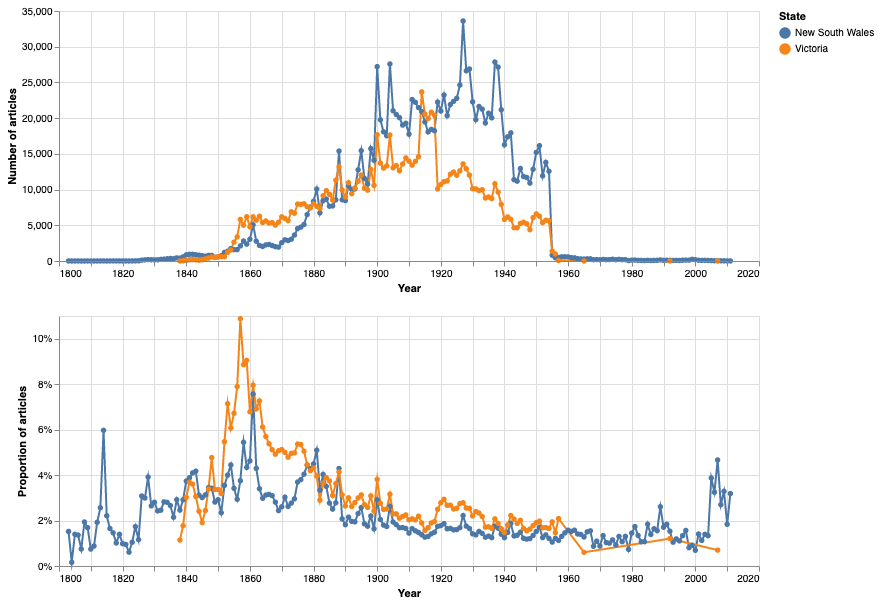

In [26]:
# Chart totals
chart5 = make_chart_totals(df_states, 'state', 'State')

# Chart proportions
chart6 = make_chart_proportions(df_states, 'state', 'State')

# Shorthand way of concatenating the two charts (note there's only one legend)
chart5 & chart6

Showing the results as a proportion of the total articles for each state does seem to show up some interesting differences. Did 10% of newspaper articles published in Victoria in 1857 really mention 'Chinese'? That seems like something to investigate in more detail.

Another way of visualising the number of results per state is by using a map! See [Map newspaper results by state](Map-newspaper-results-by-state.ipynb) for a demonstration.

## 7. Comparing a search term across different newspapers

For a more fine-grained analysis, we might want to compare the contents of different newspapers – how did their coverage or language vary over time? To do this we can use Trove's `title` facet which, despite the name, limits your results to a particular newspaper.

The `title` facet expects a numeric newspaper identifier. The easiest way of find this id number is to go to the [list of newspapers](https://trove.nla.gov.au/newspaper/about) and click on the one you're interested in. The id number will be in the url of the newspaper details page. For example, the url of the *Canberra Times* page is:

`https://trove.nla.gov.au/newspaper/title/11`

So the id number is '11'.

As with previous examples, we'll create a list of the newspapers we want to use with the `title` facet. However, the id number on it's own isn't going to be very useful in the legend of our chart, so we'll include the name of the newspaper as well. 

In [27]:
# Create a list of dictionaries, each with the 'id' and 'name' of a newspaper
newspapers = [
    {'id': 1180, 'name': 'Sydney Sun'},
    {'id': 35, 'name': 'Sydney Morning Herald'},
    {'id': 1002, 'name': 'Tribune'}
]

In [28]:
# Our search query we want to compare across newspapers
query = 'worker'

In this case the total number of articles we want to use in calculating the proportion of results is probably the total number of articles published in each particular newspaper. This should allow a more meaningful comparison between, for example, a weekly and a daily newspaper. As in the example above, we'll define a function to loop through the newspapers, and another to get the total number of articles for a given newspaper.

In [29]:
def get_newspaper_totals(newspaper_id):
    '''
    Get the total number of articles for each year for the specified newspaper.
    Parameters:
        newspaper_id - numeric Trove newspaper identifier
    Returns:
        A list of dictionaries containing 'year', 'total_results'.
    '''
    these_params = params.copy()
    
    # Set q to a single space for everything
    these_params['q'] = ' '
    
    #Set the title facet to the newspaper_id
    these_params['l-title'] = newspaper_id
    
    # Get all the year by year data
    facet_data = get_facet_data(these_params)
    return facet_data

def get_newspaper_facets(params, newspapers, query):
    '''
    Loop through the supplied list of newspapers searching for the specified query and getting the year by year results.
    Merges the search results with the total number of articles for that newspaper.
    Parameters:
        params - basic parameters to send to the API
        newspapers - a list of dictionaries with the id and name of a newspaper
        query - the search query to use
    Returns:
        A dataframe   
    '''
    dfs = []
    these_params = params.copy()
    
    # Set the query
    these_params['q'] = query
    
    # Loop through the list of newspapers
    for newspaper in newspapers:
        
        # Sewt the title facet to the id of the current newspaper
        these_params['l-title'] = newspaper['id']
        
        # Get the year by year results for this newspaper
        facet_data = get_facet_data(these_params)
        
        # Convert to a dataframe
        df = pd.DataFrame(facet_data)
        
        # Get the total number of articles published in this newspaper per year
        total_data = get_newspaper_totals(newspaper['id'])
        
        # Convert to a dataframe
        df_total = pd.DataFrame(total_data)
        
        # Merge the two dataframes
        df_merged = merge_df_with_total(df, df_total)
        
        # Create a newspaper column and set its value to the name of the newspaper
        df_merged['newspaper'] = newspaper['name']
        
        # Add the current datarame to the list
        dfs.append(df_merged)
        
    # Concatenate the dataframes and return the result
    return pd.concat(dfs)

Let's get the data!

In [32]:
df_newspapers = get_newspaper_facets(params, newspapers, query)

And make some charts!

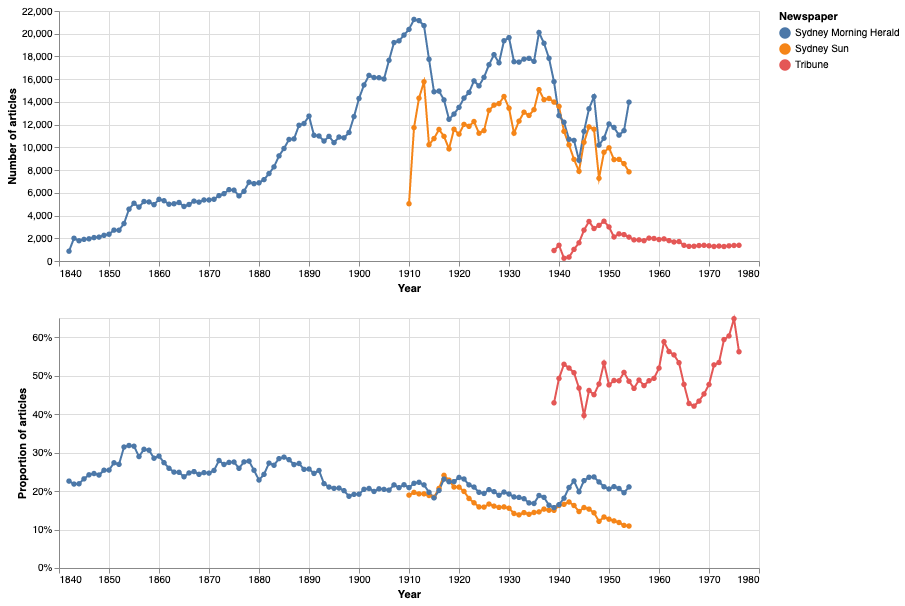

In [33]:
# Chart totals
chart7 = make_chart_totals(df_newspapers, 'newspaper', 'Newspaper')

# Chart proportions
chart8 = make_chart_proportions(df_newspapers, 'newspaper', 'Newspaper')

# Shorthand way of concatenating the two charts (note there's only one legend)
chart7 & chart8

## 8. Chart changes in illustration types over time

Let's try something a bit different and explore the *format* of articles rather than their text content. Trove includes a couple of facets that enable you to filter your search by type of illustration. First of all you have to set the `illustrated` facet to `true`, then you can specify a type of illustration using the `illtype` facet. Possible values include:

* Photo
* Cartoon
* Illustration
* Map
* Graph

First we'll create a list with all the illustration types we're interesed in.

In [34]:
ill_types = [
    'Photo',
    'Cartoon',
    'Illustration',
    'Map',
    'Graph'
]

Then we'll define a function to loop through the illustration types getting the year by year results of each.

In [35]:
def get_ill_facets(params, ill_types):
    '''
    Loop through the supplied list of illustration types getting the year by year results.
    Parameters:
        params - basic parameters to send to the API
        ill_types - a list of illustration types to use with the ill_type facet
    Returns:
        A dataframe   
    '''
    dfs = []
    ill_params = params.copy()
    
    # No query! Set q to a single space for everything
    ill_params['q'] = ' '
    
    # Set the illustrated facet to true - necessary before setting ill_type
    ill_params['l-illustrated'] = 'true'
    
    # Loop through the illustration types
    for ill_type in ill_types:
        
        # Set the ill_type facet to the current illustration type
        ill_params['l-illtype'] = ill_type
        
        # Get the year by year data
        facet_data = get_facet_data(ill_params)
        
        # Convert to a dataframe
        df = pd.DataFrame(facet_data)
        
        # Create an ill_type column and set its value to the illustration type 
        df['ill_type'] = ill_type
        
        # Add current df to the list of dfs
        dfs.append(df)
        
    # Concatenate all the dfs and return the result
    return pd.concat(dfs)

Get the data!

In [36]:
df_illtypes = get_ill_facets(params, ill_types)

To calculate proportions for these searches we'll just use the total number of articles across all of Trove we collected above. 

In [37]:
# Merge results with total articles and calculate proportions
df_illtypes_merged = merge_df_with_total(df_illtypes, df_total)

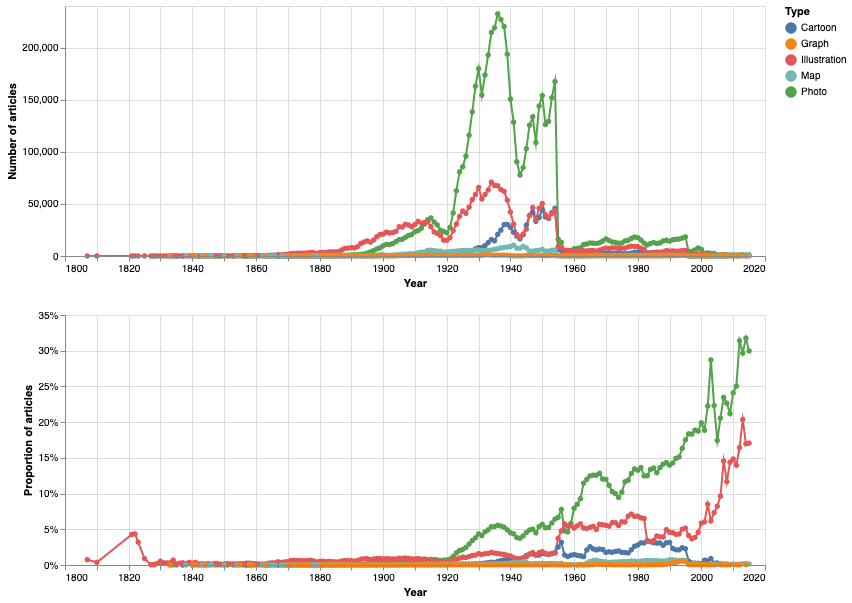

In [38]:
# Make total results chart 
chart9 = make_chart_totals(df_illtypes_merged, 'ill_type', 'Type')

# Make proportions chart
chart10 = make_chart_proportions(df_illtypes_merged, 'ill_type', 'Type')

# Shorthand way of concatenating the two charts (note there's only one legend)
chart9 & chart10

And there we have it – interesting to see the rapid increase in photos from the 1920s on.

## 9. But what are we searching?

We've seen that we can visualise Trove search results over time in a number of different ways. But what are we actually searching? In the last example, exploring illustration types, we sliced up the complete collection of Trove newspaper articles using the `ill_type` facet. This is a metadata field whose value is set by the people who processed the articles. It should be consistent, but we can't take these sorts of things for granted. Let's look at all the values in the `illtype` field.

In [39]:
ill_params = params.copy()

# No query! Set q to a single space for everything
ill_params['q'] = ' '

# Set the illustrated facet to true - necessary before setting ill_type
ill_params['l-illustrated'] = 'true'
ill_params['facet'] = 'illtype'
data = get_results(ill_params)
facets = []
for term in data['response']['zone'][0]['facets']['facet']['term']:
    # Get the state and the number of results, and convert it to integers, before adding to our results
    facets.append({'ill_type': term['search'], 'total_results': int(term['count'])})
df_ill_types = pd.DataFrame(facets)
df_ill_types
    

,ill_type,total_results
0,Photo,5773685
1,Illustration,2535397
2,Cartoon,833441
3,Map,297739
4,Cartoons,43612
5,Graph,31299
6,Chart,20
7,Unknown,6
8,Diagram,5


It's pretty consistent, but why are there entries both for 'Cartoon' and 'Cartoons'? In the past I've noticed variations in capitalisation amongst the facet values, but fortunately these seem to have been fixed. The point is that we can't take search results for granted – we have to think about how they are created.

Just as working with the Trove API enables us to view search results in different ways, so we can turn the search results against themselves to reveal some of their limitations and inconsistencies. In most of the examples above we're searching the full text of the newspaper articles for specific terms. The full text has been extracted from page images using Optical Character Recognition. The results are far from perfect, and Trove users help to correct errors. But many errors remain, and all the visualisations we've created will have been affected by them. Some articles will be missing. While we can't do much directly to improve the results, we can investigate whether the OCR errors are evenly distributed across the collection – do certain time periods, or newspapers have higher error rates?

As a final example, let's what we can find out about the variation of OCR errors over time. We'll do this by searching for a very common OCR error – 'tbe'. This is of course meant to be 'the'. This is hardly a perfect measure of OCR accuracy, but it is something we can easily measure. How does the frequency of 'tbe' change over time?

In [40]:
params['q'] = 'text:"tbe"~0'

ocr_facets = get_facet_data(params)

In [41]:
df_ocr = pd.DataFrame(ocr_facets)
df_ocr_merged = merge_df_with_total(df_ocr, df_total)

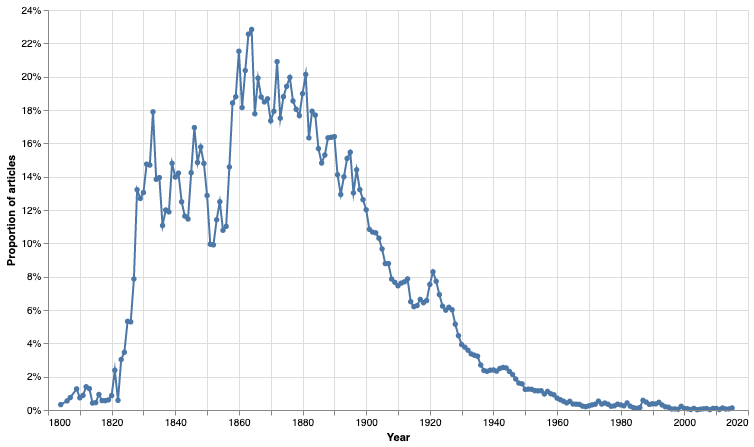

In [42]:
alt.Chart(df_ocr_merged).mark_line(point=True).encode(
        x=alt.X('year:Q', axis=alt.Axis(format='c', title='Year')),
    
        # This time we're showing the proportion (formatted as a percentage) on the Y axis
        y=alt.Y('proportion:Q', axis=alt.Axis(format='%', title='Proportion of articles')),
        tooltip=[alt.Tooltip('year:Q', title='Year'), alt.Tooltip('proportion:Q', title='Proportion', format='%')],
        
    ).properties(width=700, height=400)

In general, the proportion of articles containing 'tbe' decreases over time. This is perhaps due to improvements in paper, printing technology, or the use of more OCR-friendly fonts. The variations in the period before 1860 seem unusual. Have a greater proportion of these articles been corrected by volunteers? There might also be differences as a result of the digitisation process itself – most newspapers were digitised from microfilm, rather than hardcopy. How might that affect the results? Once again, this visualisation doesn't provide answers, but it does suggest some avenues for further investigation. Most importantly though, it suggests ways in which the accuracy of our visualisations might themselves vary over time!

One final thing we should consider is that our visualisations all show the *number of articles* that match our search query, **not** the number of times our search terms appear in newspapers. So an article in which a search term appears once has the same value in our visualisation as an article in which a search terms appears 20 times. This might mean that periods of intensive discussion around particular words are being flattened, or even rendered invisible. We can't investigate this using Trove's own search interface. To examine word frequency in greater depth, we need to harvest the text content of all the articles we're interested in and use other tools to analyse their contents. That's what the [Trove Newspaper Harvester](https://glam-workbench.github.io/trove-harvester/) is for!

## 10. Next steps

Don't just use my examples, try plugging different search terms and facet values into the examples above. 

If you find something that you'd like to investigate in more detail, you can use the [Trove Newspaper Harvester](https://glam-workbench.github.io/trove-harvester/) to download newspaper articles in bulk. Once you have all the text and metadata, you can explore the articles using a variety of text analysis tools.

## 11. Related resources

### QueryPic

[QueryPic](http://dhistory.org/querypic/) is an earlier tool I created for visualising newspaper searches in Trove (and Papers Past). It's great for creating and sharing quick visualisations. It's not quite as flexible as the approaches outlined here, but it's a good place to start your exploration of Trove data.


### QueryPic Deconstructed

This is [a Jupyter notebook version of QueryPic](https://glam-workbench.github.io/trove-newspapers/#querypic-deconstructed) that extends some of its functionality. It's meant to be run in Appmode, so you don't have worry about the code. It reproduces most of what is available in this notebook, and adds some extra options for saving your charts. A good option if you're intimidated by the code, but want to try out some of the things described in this notebook.

### Visualise a search in Papers Past

Do something similar for New Zealand newspapers in Papers Past [using this notebook](https://glam-workbench.github.io/digitalnz/#visualise-a-search-in-papers-past).

### Trove Newspaper Harvester

Once you've found something interesting in your visualisations, you can use the [Trove Newspaper Harvester](https://glam-workbench.github.io/trove-harvester/) to download the full text of thousands of articles for in-depth analysis.

## 12. Further reading

* Tim Sherratt, ['Seams and edges: dreams of aggregation, access, and discovery in a broken world'](http://discontents.com.au/seams-and-edges-dreams-of-aggregation-access-discovery-in-a-broken-world/), ALIA Online, 2015.

* Tim Sherratt, ['Hacking heritage: understanding the limits of online access'](https://hcommons.org/deposits/item/hc:18733/), preprint of a chapter submitted for publication as part of *The Routledge International Handbook of New Digital Practices in Galleries, Libraries, Archives, Museums and Heritage Sites*, forthcoming 2019.